# Analysis Walkthrough

## Determine all of the parameters

### Specify the locations of the files for X_train, X_test, and y_train. Also, there is a file that contains information about the individual stations that can be useful for models that learn for each station.

In [1]:
import os
os.chdir('..')

In [12]:
Xtrain_dir = 'solar/data/kaggle_solar/train/'
Xtest_dir = 'solar/data/kaggle_solar/test'
ytrain_file = 'solar/data/kaggle_solar/train.csv'
station_file = 'solar/data/kaggle_solar/station_info.csv'

### Import the various files. This is mostly done so that any file updates during testing are carried over to this notebook.

In [13]:
import solar.wrangle.wrangle
import solar.wrangle.subset
import solar.wrangle.engineer
import solar.analyze.model
import solar.report.submission
import numpy as np

### Set the parameters that will be used to set up the data. There are some parameters that determine the size and shape of the data but have effects other than setting up feature columns. This includes the dates that are included for testing and training, the stations considered, and whether to have X values correspond to a date or to a specific date/station combination.

In [14]:
# Choose up to 98 stations; not specifying a station means to use all that fall within the given lats and longs. If the
# parameter 'all' is given, then it will use all stations no matter the provided lats and longs
station = ['ACME', 'BEAV']
#station = ['all']

# Determine which dates will be used to train the model. No specified date means use the entire set from 1994-01-01 
# until 2007-12-31.
#train_dates = ['1994-01-01','2007-12-31']
train_dates = ['2005-11-30','2006-01-02']
# Determine the test X values to produce. There is no practical purpose to use fewer than all of the points other than
# for testing. Again, not choosing a date will use 2008-01-01 through 2012-11-30.
test_dates = ['2008-12-29', '2009-02-04']
#test_dates = ['all']
#test_dates = []
#train_dates = []
#test_dates = []

# The last parameter that is not specifically involved in feature selection in the layout to be used for training
# I have switched to almost always training for each individual station rather than having a single row for a date.
# However, I am still not beating the benchmark, and the file would grow too large to have the benchmark laid out
# with a row for each station, so I'll keep the switch. True means that each station has a row (5113 dates X 98
# stations to train the data). False means that there are 5113 rows that are being used to train the data.
station_layout = True

### First, just duplicate the functionality of the basic grid analysis

In [15]:
# Use all variables
var = ['uswrf_sfc', 'dswrf_sfc']
#var = ['all']

# Keep model 0 (the default model) as a column for each of the variables (aggregated over other dimensions)
model = [0,7]

# Aggregate over all times
times = [18,21]

# Aggregate over ACME and BEAV
#station = ['ACME', 'BEAV']
#station = ['all']

default_grid = {'type':'relative', 'axes':{'var':var, 'models':model, 'times':times,
                                          'station':station}}
just_grid = [default_grid]


### Run data extraction

In [38]:
# if I am modifying code for any of these pythons
reload(solar.wrangle.wrangle)
reload(solar.wrangle.subset)
reload(solar.wrangle.engineer)
from solar.wrangle.wrangle import SolarData

%prun input_data = SolarData.load(Xtrain_dir, ytrain_file, Xtest_dir, station_file, \
                                  train_dates, test_dates, station, \
                                  station_layout, just_grid)

In [37]:
input_data[3]

,lat,lon,elev
location,,,
ACME,34.80833,261.97675,397
BEAV,36.80253,259.46988,758


### Run through the full analysis

In [164]:
reload(solar.analyze.model)
import numpy as np
from solar.analyze.model import Model

from sklearn.linear_model import Ridge
from sklearn import metrics

error_formula = 'mean_absolute_error'
cv_splits = 10

model = Model.model(input_data[0:3], Ridge, {'alpha':np.logspace(-3,1,8,base=10)}, cv_splits, 
                    error_formula, normalize=True)

In [165]:
reload(solar.report.submission)
from solar.report.submission import Submission

preds = Submission.make_submission_file(model, input_data[1], input_data[2], {'grid'})

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/Joel/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [64]:
# here we set some aesthetic parameters so that all of our figures are nice and big
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
sns.set(style="white", context="talk")

In [28]:
y_pred = model.predict(input_data[0])

In [32]:
errors = abs(y_pred - input_data[1])/input_data[1]

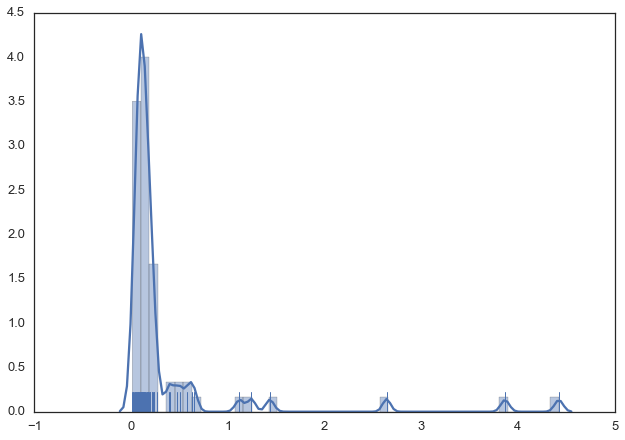

In [65]:
sns.distplot(errors, rug=True)

In [48]:
input_data[0].shape

(68, 32)

In [49]:
errors.shape

(68, 1)

In [63]:
input_data[0][(errors > 0.8).values]

relative                                          \
variable           uswrf_sfc dswrf_sfc uswrf_sfc dswrf_sfc uswrf_sfc   
model                      0         0         0         0         0   
lat_longs                 SE        SE        SW        SW        NE   
time                      18        18        18        18        18   
date       station                                                     
2005-12-07 BEAV           48       200        28       130        56   
2005-12-17 ACME           24       150        54       230        61   
           BEAV           21       110        39       180        19   
2005-12-18 ACME           23       150        44       220        31   
           BEAV           48       200        48       210        39   
2005-12-20 ACME           35       220        41       190         9   

                                                                      \
variable           dswrf_sfc uswrf_sfc dswrf_sfc uswrf_sfc dswrf_sfc   
model                      0         0         0         0         0   
lat_longs                 NE        NW        NW        SE        SE   
time                      18        18        18        21        21   
date       station                                                     
2005-12-07 BEAV          230        58       230        74       370   
2005-12-17 ACME          230        73       240        55       380   
           BEAV          100        41       170       120       530   
2005-12-18 ACME          160        42       210        38       270   
           BEAV          180        50       210        72       370   
2005-12-20 ACME           60        11        70        82       530   

                      ...                                             \
variable              ...    uswrf_sfc dswrf_sfc uswrf_sfc dswrf_sfc   
model                 ...            7         7         7         7   
lat_longs             ...           NW        NW        SE        SE   
time                  ...           18        18        21        21   
date       station    ...                                              
2005-12-07 BEAV       ...           59       230        89       440   
2005-12-17 ACME       ...           77       240        79       490   
           BEAV       ...           30       130       126       530   
2005-12-18 ACME       ...           38       200        38       280   
           BEAV       ...           50       210        77       390   
2005-12-20 ACME       ...           19       100        82       540   

                                                                                
variable           uswrf_sfc dswrf_sfc uswrf_sfc dswrf_sfc uswrf_sfc dswrf_sfc  
model                      7         7         7         7         7         7  
lat_longs                 SW        SW        NE        NE        NW        NW  
time                      21        21        21        21        21        21  
date       station                                                              
2005-12-07 BEAV           54       280       123       550       108       480  
2005-12-17 ACME          125       550       123       500       147       540  
           BEAV          116       520       123       480        99       410  
2005-12-18 ACME           97       490        87       440       106       530  
           BEAV          111       520        83       410       115       510  
2005-12-20 ACME           95       490        49       280        36       220  

[6 rows x 32 columns]

In [67]:
input_data[1][(errors > 0.8).values]

total_solar
date       location             
2005-12-07 BEAV          4230600
2005-12-17 ACME          1609800
           BEAV          1589400
2005-12-18 ACME          3166500
           BEAV          2266200
2005-12-20 ACME          2655300

In [80]:
pd.DataFrame(y_pred, index=input_data[1].index, columns=input_data[1].columns)[(errors > 0.8).values]

total_solar
date       location                
2005-12-07 BEAV      8973966.800391
2005-12-17 ACME      8730927.928196
           BEAV      7736499.841759
2005-12-18 ACME      7109328.223276
           BEAV      8255694.439097
2005-12-20 ACME      6469546.797113

In [76]:
max(errors.values)

array([ 4.42361034])

In [104]:
unstacked = input_data[0].stack('time').stack('model').stack('variable').stack('lat_longs').reset_index('model').reset_index('time').reset_index('variable').reset_index('lat_longs')

In [144]:
dswrf = unstacked[(unstacked['lat_longs'] == 'NE') & (unstacked['variable'] == 'dswrf_sfc') & (unstacked['time'] == 21)
         & (unstacked['model'] == 0)]['relative']

In [159]:
pd.DataFrame(dswrf).reset_index('station').rename(columns={'station':'location'}).unstack('location').set_index('location')

AttributeError: 'Series' object has no attribute 'set_index'

In [143]:
dswrf

""


In [136]:
pd.concat((errors,dswrf))

relative  total_solar
date       location                       
2005-11-30 ACME           NaN     0.109272
           BEAV           NaN     0.050728
2005-12-01 ACME           NaN     0.133639
           BEAV           NaN     0.100278
2005-12-02 ACME           NaN     0.087637
           BEAV           NaN     0.234225
2005-12-03 ACME           NaN     0.122034
           BEAV           NaN     0.039761
2005-12-04 ACME           NaN     0.040182
           BEAV           NaN     0.237730
2005-12-05 ACME           NaN     0.082845
           BEAV           NaN     0.066775
2005-12-06 ACME           NaN     0.172218
           BEAV           NaN     0.073014
2005-12-07 ACME           NaN     0.185014
           BEAV           NaN     1.121204
2005-12-08 ACME           NaN     0.172662
           BEAV           NaN     0.137910
2005-12-09 ACME           NaN     0.133316
           BEAV           NaN     0.117398
2005-12-10 ACME           NaN     0.105701
           BEAV           NaN     0.066239
2005-12-11 ACME           NaN     0.198911
           BEAV           NaN     0.170576
2005-12-12 ACME           NaN     0.212671
           BEAV           NaN     0.218904
2005-12-13 ACME           NaN     0.578820
           BEAV           NaN     0.105412
2005-12-14 ACME           NaN     0.122169
           BEAV           NaN     0.031222
...                       ...          ...
2005-12-19 ACME           230          NaN
           BEAV           160          NaN
2005-12-20 ACME           320          NaN
           BEAV           530          NaN
2005-12-21 ACME           560          NaN
           BEAV           530          NaN
2005-12-22 ACME           540          NaN
           BEAV           530          NaN
2005-12-23 ACME           550          NaN
           BEAV           380          NaN
2005-12-24 ACME           560          NaN
           BEAV           540          NaN
2005-12-25 ACME           550          NaN
           BEAV           530          NaN
2005-12-26 ACME           560          NaN
           BEAV           550          NaN
2005-12-27 ACME           570          NaN
           BEAV           540          NaN
2005-12-28 ACME           550          NaN
           BEAV           520          NaN
2005-12-29 ACME           520          NaN
           BEAV           530          NaN
2005-12-30 ACME           580          NaN
           BEAV           550          NaN
2005-12-31 ACME           580          NaN
           BEAV           510          NaN
2006-01-01 ACME           530          NaN
           BEAV           560          NaN
2006-01-02 ACME           570          NaN
           BEAV           550          NaN

[136 rows x 2 columns]

In [121]:
pd.concat([dswrf,errors])

0  total_solar
date       station                  
2005-11-30 ACME     570          NaN
           BEAV     560          NaN
2005-12-01 ACME     580          NaN
           BEAV     560          NaN
2005-12-02 ACME     560          NaN
           BEAV     540          NaN
2005-12-03 ACME     570          NaN
           BEAV     470          NaN
2005-12-04 ACME     550          NaN
           BEAV     550          NaN
2005-12-05 ACME     590          NaN
           BEAV     570          NaN
2005-12-06 ACME     540          NaN
           BEAV     570          NaN
2005-12-07 ACME     120          NaN
           BEAV     550          NaN
2005-12-08 ACME     580          NaN
           BEAV     570          NaN
2005-12-09 ACME     570          NaN
           BEAV     550          NaN
2005-12-10 ACME     570          NaN
           BEAV     540          NaN
2005-12-11 ACME     490          NaN
           BEAV     510          NaN
2005-12-12 ACME     530          NaN
           BEAV     390          NaN
2005-12-13 ACME     510          NaN
           BEAV     330          NaN
2005-12-14 ACME     510          NaN
           BEAV     540          NaN
...                 ...          ...
2005-12-19 ACME     NaN     0.475143
           BEAV     NaN     0.510051
2005-12-20 ACME     NaN     1.436465
           BEAV     NaN     0.198671
2005-12-21 ACME     NaN     0.649446
           BEAV     NaN     0.113861
2005-12-22 ACME     NaN     0.133250
           BEAV     NaN     0.068852
2005-12-23 ACME     NaN     0.013269
           BEAV     NaN     0.271759
2005-12-24 ACME     NaN     0.099694
           BEAV     NaN     0.092930
2005-12-25 ACME     NaN     0.150981
           BEAV     NaN     0.091119
2005-12-26 ACME     NaN     0.146041
           BEAV     NaN     0.121869
2005-12-27 ACME     NaN     0.102915
           BEAV     NaN     0.391732
2005-12-28 ACME     NaN     0.124311
           BEAV     NaN     0.053134
2005-12-29 ACME     NaN     0.192127
           BEAV     NaN     0.022048
2005-12-30 ACME     NaN     0.166686
           BEAV     NaN     0.069653
2005-12-31 ACME     NaN     0.400195
           BEAV     NaN     0.021857
2006-01-01 ACME     NaN     0.077016
           BEAV     NaN     0.222145
2006-01-02 ACME     NaN     0.140441
           BEAV     NaN     0.097205

[136 rows x 2 columns]

In [ ]:
sns.jointplot("total_solar","dswrf", data=drinks[(drinks.beer < 100) & (drinks.wine < 30)] , kind = "kde")

In [87]:
import netCDF4 as nc
X = nc.Dataset('solar/data/kaggle_solar/train/dswrf_sfc_latlon_subset_19940101_20071231.nc','r+').variables.values()
X[-1][0:10,0,2:3,:,:]

array([[[[ 210.,  210.,  220., ...,  110.,  180.,  170.],
         [ 200.,  210.,  210., ...,   70.,   90.,  140.],
         [ 200.,  200.,  200., ...,   40.,   40.,   70.],
         ..., 
         [ 160.,  160.,  170., ...,  210.,  210.,  200.],
         [ 150.,  150.,  160., ...,  160.,  150.,  170.],
         [ 150.,  150.,  150., ...,  100.,   80.,   90.]]],


       [[[ 200.,  210.,  210., ...,  270.,  280.,  270.],
         [ 200.,  200.,  210., ...,  260.,  270.,  270.],
         [ 200.,  200.,  210., ...,  250.,  260.,  260.],
         ..., 
         [ 170.,  170.,  170., ...,  110.,  110.,  120.],
         [ 160.,  160.,  160., ...,  110.,  100.,  110.],
         [ 140.,  160.,  160., ...,   80.,   90.,  130.]]],


       [[[ 210.,  210.,  220., ...,  180.,  120.,  100.],
         [ 200.,  210.,  210., ...,   90.,  110.,   80.],
         [ 190.,  200.,  200., ...,   80.,  100.,  100.],
         ..., 
         [ 160.,  160.,  170., ...,   90.,  120.,  160.],
         [ 150.,  1

In [35]:
# This just uses the station_names as another feature
stat_names = {'type':'station_names'}
stat_feats = [stat_names]

### Next, we start to layout the features to include. The two most important (and complicated) are 'absolute', which just reports out the weather variables at specific GEFS, times, and models, and 'relative' which uses a grid to identify nearby GEFS for weather measurements based on the location of the station. The second option makes the most sense when using the station_layout above, but it will work with either layout.

In [13]:
# A very simple model would just take the average value of all variables at all locations, using all models over the
# course of the day. Here, only the var parameter and one value of the model is expanded. 
# All of the other axes are aggregated using an aggregation function. In this case, the mean value. 
# This will provide a 15 aggregated columns for model 0 and 15 aggregated columns for the mean of models 1 though 10.
# In this case, setting station_layout to false would make the most sense because the measurements will be repeated
# for each station. However, for consistency in this walkthough, I will just keep it in the station_layout.

# Dimensions without aggregation

# Use all variables
var = ['all']

# Keep model 0 (the default model) as a column for each of the variables (aggregated over other dimensions)
model1 = [0]

# Dimensions with aggregation

# Aggregate over all other models (excluding model 0, which is used directly)
model2 = range(1,11)

# Aggregate over all times
times = ['all']

# Aggregate over all latitudes which surround Mesonet stations (exclude those that are outside of the main grid)
lats = range(33,38)

# Same as for lats
longs = range(257,267)

all_avgs = {'type':'absolute', 'full_axes':{'var':var, 'models':model1}, 
            'agg_axes':{'models':[model2,[np.mean]], 'times':[times, [np.mean, np.sum]], 'lats':[lats,[np.median]],
                        'longs':[longs,[np.median]]}}

avgs_feats = [all_avgs]

In [14]:
# A similar example using a surrounding grid for each station. There are no lat or long options for this type of
# feature set

# Dimensions without aggregation

# Use all variables
var = ['all']

# Keep model 0 (the default model) as a column for each of the variables (aggregated over other dimensions)
model1 = [0]

# Dimensions with aggregation

# Aggregate over all other models (excluding model 0, which is used directly)
model2 = range(1,11)

# Aggregate over all times
times = ['all']

# Create a column for each member of the grid. All or nothing for gefs now. Could specify but currently see no need
# for it. We could also take an aggregate measure of the gefs (including interpolate). That doesn't work for the
# other dimensions

gefs = ['all']

grid_avgs = {'type':'relative', 'full_axes':{'var':var, 'models':model1, 'gefs':gefs}, 
            'agg_axes':{'models':[model2,[np.mean]], 'times':[times, [np.mean, np.sum]]}}

grid_feats = [grid_avgs]

In [16]:
# A similar example using a surrounding grid for each station. Now, just average over the grid

# Dimensions without aggregation

# Use all variables
var = ['all']

# Keep model 0 (the default model) as a column for each of the variables (aggregated over other dimensions)
model1 = [0]

# Dimensions with aggregation

# Aggregate over all other models (excluding model 0, which is used directly)
model2 = range(1,11)

# Aggregate over all times
times = ['all']

# Create a column for each member of the grid. All or nothing for gefs now. Could specify but currently see no need
# for it. We could also take an aggregate measure of the gefs (including interpolate). That doesn't work for the
# other dimensions

gefs = ['all']

grid_avgs = {'type':'relative', 'full_axes':{'var':var, 'models':model1}, 
            'agg_axes':{'models':[model2,[np.mean]], 'times':[times, [np.mean, np.sum]], 'gefs':[gefs, [np.mean]]}}

gefs_mean_feats = [grid_avgs]

In [35]:
# This just uses the station_names as another feature
stat_names = {'type':'station_names'}
stat_feats = [stat_names]

In [9]:
import os
os.chdir('..')

In [21]:
# if I am modifying code for any of these pythons
reload(solar.wrangle.wrangle)
reload(solar.wrangle.subset)
reload(solar.wrangle.engineer)
from solar.wrangle.wrangle import SolarData

%prun input_data = SolarData.load(Xtrain_dir, ytrain_file, Xtest_dir, station_file, \
                                  train_dates, test_dates, station, \
                                  station_layout, just_grid)

In [49]:
input_data[3]

,lat,lon,elev
location,,,
ACME,34.80833,261.97675,397
BEAV,36.80253,259.46988,758
